In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt

# Table of Contents
1. [Cleaning](#Cleaning)
2. [Imputation Analysis](#Imputation-Analysis)
   - [Recent Value Imputation](#Recent-Value-Imputation)
   - [KNN Imputation](#KNN-Imputation)
3. [Further Cleaning](#Further-Cleaning)
   - [One Hot Encoding of all categorical vars](#One-Hot-Encoding-of-all-categorical-vars)
   - [PCA](#PCA)
   - [VIF](#VIF)
   - [Final Dataset (some additions)](#Final-Dataset-(some-additions))
   - [Extracting data for 2017)](Extracting-data-for-2017)
4. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
   - [Across Income Levels](#Across-Income-Levels)
   - [Across Regions](#Across-Regions)

# Cleaning

Using merged data that Schaff created


In [2]:
merged_data = pd.read_csv("D:\\Documents\\LUMS\\7th Semester Courses\\SPROJ\\Schaff Data Work\\merged_data_1.csv")

In [3]:
# removing some more vars

# List of columns to drop
columns_to_drop = [
    'received_wages_acct_fees_pct', 
    'received_wages_acct_fees_wage_receivers_pct',
    'received_wages_acc_pct',
    'received_wages_acc_wage_receivers_pct',
    'received_wages_cash_pct',
    'received_wages_cash_wage_receivers_pct',
    'received_wages_fin_account_pct',
    'received_wages_fin_account_wage_receivers_pct',
    'received_wages_mobile_wage_receivers_pct',
    'received_wages_mobile_pct',
    'received_wages_card_pct',
    'received_wages_card_wage_receivers_pct',
    'used_checks_payment_pct',
    'bitstream_access_service',
    'skill_connecting_installing_devices',
    'skill_creating_presentations',
    'hh_own_desktop_computer_pct',
    'skill_software_run_over_the_internet_female',
    'hh_with_internet_access_at_home_pct',
    'hh_own_computer_pct',
    'individuals_using_computer_pct',
    'individuals_using_smart_phone_pct',
    'individuals_using_internet_pct',
    'international_bandwidth_usage',
    'number_of_internet_exchange_points',
    'number_of_internet_service_providers',
    'skill_social_networks_pct',
    'skill_software_run_over_the_internet_rural_pct',
    'sms_sent',
    'skill_e_mails_attached_files_pct',
    'service_activation_time_for_fixed_broadband_service',
    'hh_own_tablet_pct',  
    'skill_software_run_over_the_internet_male_pct'  
]

# Drop specified columns from DataFrame
merged_data = merged_data.drop(columns=columns_to_drop)



In [4]:
# bringing in chain mapping

variable_mapping_wb = pd.read_excel("D:\\Documents\\LUMS\\7th Semester Courses\\SPROJ\\Primary Data\\concise_variable_names.xlsx", sheet_name= "world bank")

variable_mapping_meta = pd.read_excel("D:\\Documents\\LUMS\\7th Semester Courses\\SPROJ\\Primary Data\\concise_variable_names.xlsx", sheet_name= "meta")

variable_mapping_itu = pd.read_excel("D:\\Documents\\LUMS\\7th Semester Courses\\SPROJ\\Primary Data\\concise_variable_names.xlsx", sheet_name= "itu")


In [5]:
# mapping chain to merged data

chain_grouping_dict_wb = variable_mapping_wb.set_index('Concise Variable Name')['Chain Grouping'].to_dict()
chain_grouping_dict_meta = variable_mapping_meta.set_index('Concise Variable Name')['Chain Grouping'].to_dict()
chain_grouping_dict_itu = variable_mapping_itu.set_index('Concise Variable Name')['Chain Grouping'].to_dict()

combined = {}
combined.update(chain_grouping_dict_itu)
combined.update(chain_grouping_dict_meta)
combined.update(chain_grouping_dict_wb)

chain_grouping_row = [combined.get(col, "") for col in merged_data.columns]
chain_grouping_df = pd.DataFrame([chain_grouping_row], columns=merged_data.columns)
updated_merged_data = pd.concat([chain_grouping_df, merged_data], ignore_index=True)


In [6]:
# more cleaning: two reasons: repeated vars or have too many missing values

updated_merged_data = updated_merged_data.drop(columns=['internet_users_pct.2', 'internet_users_pct.3','hh_own_computer_pct.1','hh_own_computer_pct.2','hh_own_computer_pct.3','country_code_y','borrowed_for_edu_pct','used_phone_internet_access_account_with_acc_pct','region', 'withdrawal_atm_with_acc_pct','withdrawal_teller_with_acc_pct','saved_education_pct','outstanding_housing_loan_pct','paid_school_fees_pct','mobile_money_indep_pct','mobile_money_indep_mobile_acc_pct','borrowed_mobile_pct','store_money_mobile_pct','store_money_mobile_with_acc_pct'])
updated_merged_data.loc[0,'internet_users_pct.1'] = 'Control'

In [7]:
# creating mapping

first_row = updated_merged_data.iloc[0]
order = {
    np.float64:0,
    np.nan: 1,
    '':2,
    'Control': 3,
    'X Variable': 4,
    'Intermediate Outcomes': 5,
    'Financial well-being': 6
}

sorted_columns = sorted(updated_merged_data.columns, key=lambda col: order.get(first_row[col], 5))
updated_merged_data = updated_merged_data[sorted_columns]

year_index = updated_merged_data.columns.get_loc('year')
new_order = updated_merged_data.columns.tolist()  # Get current columns as a list
new_order.pop(year_index)  # Remove the year column from its current position
new_order.insert(1, 'year')  # Insert 'year' at the third position (index 2)
updated_merged_data = updated_merged_data[new_order]
column_names = updated_merged_data.columns.tolist()
# Assuming the first row has descriptions, extract it
chain_grouping = updated_merged_data.iloc[0].tolist()
# Create a dictionary of column name to description
chain_grouping_dict = dict(zip(column_names, chain_grouping))

In [8]:
# without the chain grouping row

updated_merged_data = updated_merged_data[1:]

In [9]:
# removing % sign to prepare for analysis

index_start = updated_merged_data.columns.get_loc('bank_account_indep_noacct_pct')
index_end = updated_merged_data.columns.get_loc('worry_old_age_very_worried_pct')

for column in updated_merged_data.columns[index_start:index_end + 1]:  # +1 to include the end index
    updated_merged_data[column] = updated_merged_data[column].str.replace('%', '').astype(float)

# Imputation Analysis

## Recent Value Imputation

In [10]:
%%capture
# imputation technique 1: for each country, insert in 2021 its mean for each variable if the variable datatype is numeric. if the datatype is string, insert the mode of that column

# Function to check and impute missing values for 2021 using the most recent value from 2017 or after
def impute_2021_values(group):
    # Filter the group to only include data from 2017 onwards
    recent_data = group[group['year'] >= 2017]
    
    # Get the row for 2021
    data_2021 = group[group['year'] == 2021]
    
    # Iterate through each column (skip 'country' and 'year' columns)
    for col in group.columns:
        if col in ['country', 'year']:  # Skip 'country' and 'year' columns
            continue
        
        # Check if there's a missing value for 2021 in this column
        if pd.isna(data_2021[col].iloc[0]):
            # Check if there are any non-missing values from 2017 or later
            if recent_data[col].notna().any():
                # Get the most recent non-missing value from 2017 onward
                recent_value = recent_data[col].ffill().bfill().iloc[-1]
                
                # Fill the missing value for 2021 with the most recent value
                group.loc[group['year'] == 2021, col] = recent_value
    
    return group

# Apply the function group-wise by country
updated_merged_data = updated_merged_data.groupby('country', group_keys=False).apply(impute_2021_values);

In [11]:
whole_Data = updated_merged_data

Working with year 2021 only

In [12]:
# rows removed where y vars dont have any value

columns_to_check = [
    'worry_money_old_age_pct',
    'worry_money_expenses_pct',
    'worry_money_medical_pct',
    'worry_money_education_pct',
    'worry_medical_not_worried_pct',
    'worry_medical_somewhat_worried_pct',
    'worry_medical_very_worried_pct',
    'worry_school_not_worried_pct',
    'worry_school_somewhat_worried_pct',
    'worry_school_very_worried_pct',
    'worry_expenses_not_worried_pct',
    'worry_expenses_very_worried_pct',
    'worry_expenses_somewhat_worried_pct',
    'worry_old_age_not_worried_pct',
    'worry_old_age_somewhat_worried_pct',
    'worry_old_age_very_worried_pct'
]

#these self reported, so they need to be about perception of financial well being 
# Drop rows with missing values in any of the specified columns
#look into the survey that was designed to see what exactly the categories mean
#look into creating index 
#descriptive statistics of outcomes 
updated_merged_data = updated_merged_data.dropna(subset=columns_to_check,how='all')
updated_merged_data = updated_merged_data.dropna(how='all', axis=1)
filtered_merged_data = updated_merged_data[updated_merged_data['year'] == 2021]
filtered_merged_data = filtered_merged_data.reset_index(drop=True)


## KNN Imputation

In [13]:
# KNN regression
# using cross validation to get the best k

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score


# Assuming you want to calculate MSE and R² score
best_k_values = {}
best_mse_scores = {}
best_r2_scores = {}

# Define the range of k values to test
k_values = range(1, 6)

# Filter target columns starting with 'skill'
target_columns = filtered_merged_data.filter(regex='^skill').columns.tolist()

for column in target_columns:
    print(f"Processing column: {column}")
    working_data = filtered_merged_data.sort_values(by=column, na_position='last')
    working_data = working_data.reset_index(drop=True)

    # Find the first missing value index
    missing_start_index = working_data[working_data[column].isna()].index.min()

    # Check if there are missing values
    if pd.isna(missing_start_index):
        print(f"No missing values for column {column}. Skipping...")
        continue

    # Create training data up to the first missing value
    x_train = working_data.iloc[0:missing_start_index, list(range(3, 33)) + [38]]
    y_train = working_data.iloc[0:missing_start_index, working_data.columns.get_loc(column)]

    # Standardize the features
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)

    # Lists to store cross-validation scores for each k
    mse_scores = []
    r2_scores = []

    for k in k_values:
        knn = KNeighborsRegressor(n_neighbors=k)
        
        # Calculate cross-validation scores
        mse_cv_score = -cross_val_score(knn, x_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
        r2_cv_score = cross_val_score(knn, x_train_scaled, y_train, cv=5, scoring='r2')

        # Store the mean scores
        mse_scores.append(mse_cv_score.mean())
        r2_scores.append(r2_cv_score.mean())
    
    # Find the best k value based on MSE
    best_k = k_values[mse_scores.index(min(mse_scores))]
    best_k_values[column] = best_k

    # Get the best MSE and R² scores for the best k
    best_mse = min(mse_scores)
    best_r2 = max(r2_scores)
    best_mse_scores[column] = best_mse
    best_r2_scores[column] = best_r2

    print(f"Best k for {column}: {best_k}, Best MSE: {best_mse:.4f}, Best R² Score: {best_r2:.4f}")

# Display the best k values and scores for each column
print("\nBest k values for each column:")
print(best_k_values)


Processing column: skill_installing_software_pct
Best k for skill_installing_software_pct: 4, Best MSE: 336.1147, Best R² Score: -14.4345
Processing column: skill_internet_banking_pct
Best k for skill_internet_banking_pct: 3, Best MSE: 501.6323, Best R² Score: -68.2944
Processing column: skill_transferring_files_pct
Best k for skill_transferring_files_pct: 4, Best MSE: 276.8071, Best R² Score: -19.3194
Processing column: skill_uploading_content_pct
Best k for skill_uploading_content_pct: 5, Best MSE: 344.0530, Best R² Score: -52.4433
Processing column: skill_software_run_over_the_internet_urban_pct
Best k for skill_software_run_over_the_internet_urban_pct: 3, Best MSE: 116.1967, Best R² Score: -78.2317
Processing column: skill_arithmetic_formula_spreadsheet_pct
Best k for skill_arithmetic_formula_spreadsheet_pct: 4, Best MSE: 177.1196, Best R² Score: -14.0107
Processing column: skill_copy_and_paste_pct
Best k for skill_copy_and_paste_pct: 3, Best MSE: 506.1825, Best R² Score: -36.7615


In [14]:
# KNN regression: continued
# actual imputation

target_columns = filtered_merged_data.filter(regex='^skill').columns.tolist()

for column in target_columns:
    working_data = filtered_merged_data.sort_values(by=column, na_position='last')
    working_data = working_data.reset_index(drop=True)
    missing_start_index = working_data[working_data[column].isna()].index.min()
    x_train = working_data.iloc[0:missing_start_index, list(range(3, 33)) + [38]]
    column_number = working_data.columns.get_loc(column)
    y_train = working_data.iloc[0:missing_start_index, column_number]

    x_test = working_data.iloc[missing_start_index:, list(range(3, 33)) + [38]]

    # Standardize the features using StandardScaler
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    k = best_k_values[column]
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(x_train_scaled, y_train)

    # predicting
    y_pred = knn.predict(x_test_scaled)

    # Impute the predicted values back into the original DataFrame
    working_data.loc[working_data.index[missing_start_index:], column] = y_pred
    filtered_merged_data = working_data.sort_values(by='country', ascending=True)
    filtered_merged_data = filtered_merged_data.reset_index(drop=True)

In [15]:
# removing columns that still have missing values after imputation
missing_columns = filtered_merged_data.columns[filtered_merged_data.isna().any()].tolist()
remove_values = ['mkt_structure_fibre','mkt_structure_fixed_wireless_broadband']
filtered_list = [x for x in missing_columns if x not in remove_values]

filtered_merged_data = filtered_merged_data.drop(columns=filtered_list)

In [16]:
%%capture
# KNN classification
# cross validation

# Dictionaries to store best k values and scores for each column
best_k_values = {}
best_accuracy_scores = {}

# Range of k values to test
k_values = range(1, 6)

# Target columns to impute
target_columns = ['mkt_structure_fibre', 'mkt_structure_fixed_wireless_broadband']

for column in target_columns:
    print(f"Processing column: {column}")
    
    # Sort data by the current column and reset the index
    working_data = filtered_merged_data.sort_values(by=column, na_position='last').reset_index(drop=True)
    
    # Find the first missing value index
    missing_start_index = working_data[working_data[column].isna()].index.min()
    
    # Check if there are missing values
    if pd.isna(missing_start_index):
        print(f"No missing values for column {column}. Skipping...")
        continue

    # Training data (non-missing) and labels
    x_train = working_data.iloc[:missing_start_index, list(range(3, 33)) + [38]]
    y_train = working_data.iloc[:missing_start_index, working_data.columns.get_loc(column)]
    
    # Standardize the features
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)

    # Lists to store cross-validation scores for each k
    accuracy_scores = []

    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        
        # Calculate cross-validation accuracy scores
        accuracy_cv_score = cross_val_score(knn, x_train_scaled, y_train, cv=5, scoring='accuracy')
        
        # Store the mean accuracy score
        accuracy_scores.append(accuracy_cv_score.mean())
    
    # Find the best k value based on the highest accuracy
    best_k = k_values[accuracy_scores.index(max(accuracy_scores))]
    best_k_values[column] = best_k

    # Get the best accuracy score for the best k
    best_accuracy = max(accuracy_scores)
    best_accuracy_scores[column] = best_accuracy

    print(f"Best k for {column}: {best_k}, Best Accuracy: {best_accuracy:.4f}")

# Display the best k values and scores for each column
print("\nBest k values for each column:")
print(best_k_values);


In [17]:
# KNN classification continued

# actual imputation

target_columns = ['mkt_structure_fibre','mkt_structure_fixed_wireless_broadband']

for column in target_columns:
    # Sort data by the current column and reset the index
    working_data = filtered_merged_data.sort_values(by=column, na_position='last').reset_index(drop=True)
    
    # Find the index where missing values start
    missing_start_index = working_data[working_data[column].isna()].index.min()
    
    # Training and test sets based on rows above and below the missing data
    x_train = working_data.iloc[:missing_start_index, list(range(3, 33)) + [38]]
    column_number = working_data.columns.get_loc(column)
    y_train = working_data.iloc[:missing_start_index, column_number]
    
    x_test = working_data.iloc[missing_start_index:, list(range(3, 33)) + [38]]
    
    # Standardize the features using StandardScaler
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    
    # Use the best k value for the KNN classifier
    k = best_k_values[column]
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train_scaled, y_train)
    
    # Predicting the missing values for the current target column
    y_pred = knn.predict(x_test_scaled)
    
    # Impute predicted values back into the DataFrame
    working_data.loc[working_data.index[missing_start_index:], column] = y_pred
    
    # Sort and reset the main DataFrame after imputation
    filtered_merged_data = working_data.sort_values(by='country', ascending=True).reset_index(drop=True)

# Further Cleaning

## One Hot Encoding of all categorical vars

In [18]:
# mkt_structure_fibre
filtered_merged_data['mkt_structure_fibre_monopoly'] = filtered_merged_data['mkt_structure_fibre'].apply(
    lambda x: 1 if x == 'Monopoly' else 0 if x in ['Full competition (year when competition was introduced)', 'Partial competition (year when competition was introduced)'] else x)

filtered_merged_data['mkt_structure_fibre_partialcomp'] = filtered_merged_data['mkt_structure_fibre'].apply(
    lambda x: 1 if x == 'Partial competition (year when competition was introduced)' else 0 if x in ['Full competition (year when competition was introduced)', 'Monopoly'] else x)

filtered_merged_data['mkt_structure_fibre_fullcomp'] = filtered_merged_data['mkt_structure_fibre'].apply(
    lambda x: 1 if x == 'Full competition (year when competition was introduced)' else 0 if x in ['Monopoly', 'Partial competition (year when competition was introduced)'] else x)

filtered_merged_data = filtered_merged_data.drop(columns=['mkt_structure_fibre'])

In [19]:
# mkt_structure_fixed_wireless_broadband

filtered_merged_data['mkt_structure_fixed_wireless_broadband_monopoly'] = filtered_merged_data['mkt_structure_fixed_wireless_broadband'].apply(
    lambda x: 1 if x == 'Monopoly' else 0 if x in ['Full competition (year when competition was introduced)', 'Partial competition (year when competition was introduced)'] else x)

filtered_merged_data['mkt_structure_fixed_wireless_broadband_partialcomp'] = filtered_merged_data['mkt_structure_fixed_wireless_broadband'].apply(
    lambda x: 1 if x == 'Partial competition (year when competition was introduced)' else 0 if x in ['Full competition (year when competition was introduced)', 'Monopoly'] else x)

filtered_merged_data['mkt_structure_fixed_wireless_broadband_fullcomp'] = filtered_merged_data['mkt_structure_fixed_wireless_broadband'].apply(
    lambda x: 1 if x == 'Full competition (year when competition was introduced)' else 0 if x in ['Monopoly', 'Partial competition (year when competition was introduced)'] else x)

filtered_merged_data = filtered_merged_data.drop(columns=['mkt_structure_fixed_wireless_broadband'])

In [20]:
# income_group

filtered_merged_data['income_group_high_income'] = filtered_merged_data['income_group'].apply(
    lambda x: 1 if x == 'High income' else 0 if x in ['Upper middle income', 'Lower middle income','Low income'] else x)

filtered_merged_data['income_group_upper_middle_income'] = filtered_merged_data['income_group'].apply(
    lambda x: 1 if x == 'Upper middle income' else 0 if x in ['High income', 'Lower middle income','Low income'] else x)

filtered_merged_data['income_group_lower_middle_income'] = filtered_merged_data['income_group'].apply(
    lambda x: 1 if x == 'Lower middle income' else 0 if x in ['Upper middle income', 'High income','Low income'] else x)

filtered_merged_data['income_group_low_income'] = filtered_merged_data['income_group'].apply(
    lambda x: 1 if x == 'Low income' else 0 if x in ['Upper middle income', 'Lower middle income','High income'] else x)

filtered_merged_data = filtered_merged_data.drop(columns=['income_group'])

## PCA

Exploring

In [21]:
# correlation
numeric_columns = filtered_merged_data.select_dtypes(include=['number']).columns.tolist()

correlation_matrix = filtered_merged_data[numeric_columns].corr()

<Axes: >

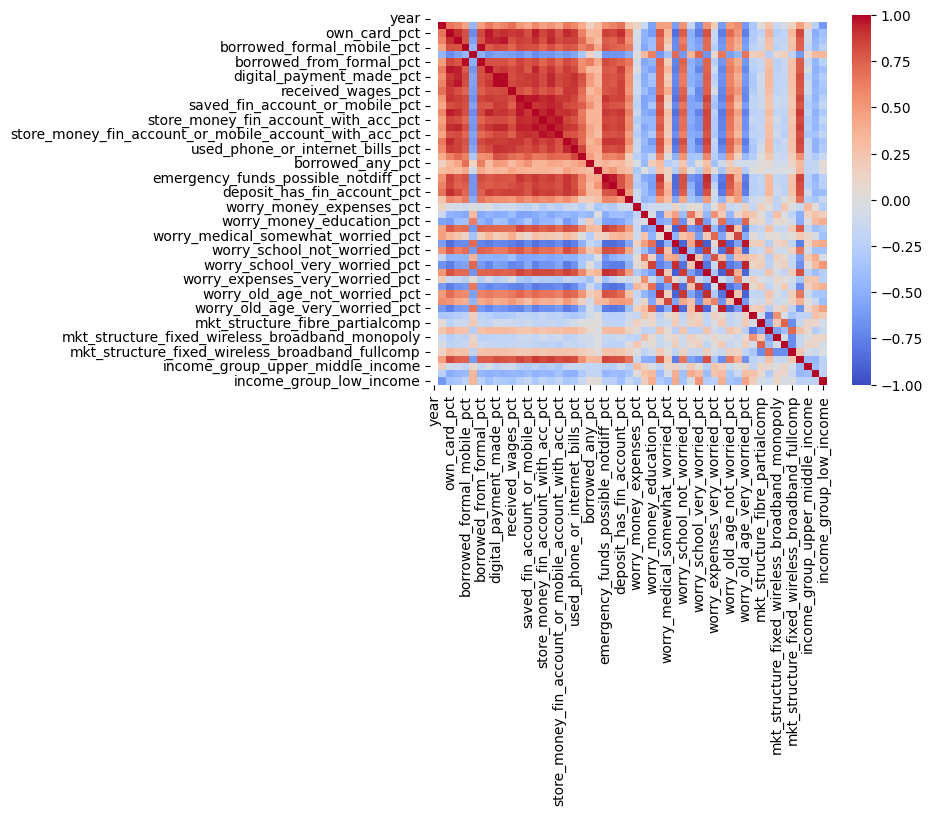

In [22]:
sns.heatmap(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)

In [23]:
threshold = 0.6
correlated_pairs = []

# Iterate through the correlation matrix
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            # Store pairs of variables with their correlation coefficient
            correlated_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

# Convert to DataFrame for better visualization
correlated_pairs_df = pd.DataFrame(correlated_pairs, columns=['Variable 1', 'Variable 2', 'Correlation Coefficient'])

print("\nVariables with correlation greater than 0.6 or less than -0.6:")
print(correlated_pairs_df)


Variables with correlation greater than 0.6 or less than -0.6:
                     Variable 1                           Variable 2  \
0                  own_card_pct                       own_mobile_pct   
1                   account_pct                       own_mobile_pct   
2                   account_pct                         own_card_pct   
3    borrowed_formal_mobile_pct                         own_card_pct   
4    borrowed_formal_mobile_pct                          account_pct   
..                          ...                                  ...   
449    income_group_high_income       worry_expenses_not_worried_pct   
450    income_group_high_income  worry_expenses_somewhat_worried_pct   
451    income_group_high_income        worry_old_age_not_worried_pct   
452    income_group_high_income       worry_old_age_very_worried_pct   
453     income_group_low_income                       own_mobile_pct   

     Correlation Coefficient  
0                   0.661299  
1        

Applying PCA

In [24]:
column_name = 'worry_money_old_age_pct'
start = filtered_merged_data.columns.get_loc(column_name)
column_name = 'worry_old_age_very_worried_pct'
end = filtered_merged_data.columns.get_loc(column_name)

columns_in_range = filtered_merged_data.columns[start:end]
print(columns_in_range)


not_worried_df = filtered_merged_data[['worry_expenses_not_worried_pct','worry_school_not_worried_pct','worry_old_age_not_worried_pct','worry_medical_not_worried_pct']]
somewhat_worried_df = filtered_merged_data[['worry_expenses_somewhat_worried_pct','worry_school_somewhat_worried_pct','worry_old_age_somewhat_worried_pct','worry_medical_somewhat_worried_pct']]
very_worried_df = filtered_merged_data[['worry_expenses_very_worried_pct','worry_school_very_worried_pct','worry_old_age_very_worried_pct','worry_medical_very_worried_pct']]
worried_df = filtered_merged_data[['worry_money_old_age_pct', 'worry_money_expenses_pct', 'worry_money_medical_pct', 'worry_money_education_pct']]

Index(['worry_money_old_age_pct', 'worry_money_expenses_pct',
       'worry_money_medical_pct', 'worry_money_education_pct',
       'worry_medical_not_worried_pct', 'worry_medical_somewhat_worried_pct',
       'worry_medical_very_worried_pct', 'worry_school_not_worried_pct',
       'worry_school_somewhat_worried_pct', 'worry_school_very_worried_pct',
       'worry_expenses_not_worried_pct', 'worry_expenses_very_worried_pct',
       'worry_expenses_somewhat_worried_pct', 'worry_old_age_not_worried_pct',
       'worry_old_age_somewhat_worried_pct'],
      dtype='object')


In [25]:
# not worried index creation
scaler = StandardScaler()
normalized_data = scaler.fit_transform(not_worried_df)

pca = PCA(n_components=4)
pca.fit(normalized_data)
transformed_data = pca.transform(normalized_data)
component_loadings = pca.components_
explained_variance_ratios = pca.explained_variance_ratio_
transformed_data = pca.transform(normalized_data)
explained_variance_ratios = pca.explained_variance_ratio_
weights = np.abs(component_loadings) / np.sum(np.abs(component_loadings), axis=1, keepdims=True)
not_worried_weights = weights[:1]
not_worried_df_indexed = not_worried_df * not_worried_weights.flatten()
print(not_worried_weights)


[[0.25165353 0.24499663 0.25127942 0.25207042]]


In [26]:
# somewhat worried index creation
scaler = StandardScaler()
normalized_data = scaler.fit_transform(somewhat_worried_df)

pca = PCA(n_components=4)
pca.fit(normalized_data)
transformed_data = pca.transform(normalized_data)
component_loadings = pca.components_
explained_variance_ratios = pca.explained_variance_ratio_
transformed_data = pca.transform(normalized_data)
explained_variance_ratios = pca.explained_variance_ratio_
weights = np.abs(component_loadings) / np.sum(np.abs(component_loadings), axis=1, keepdims=True)
somewhat_worried_weights = weights[:1]
somewhat_worried_df_indexed = somewhat_worried_df * somewhat_worried_weights.flatten()
print(somewhat_worried_weights)

[[0.25732131 0.09907382 0.32622286 0.31738201]]


In [27]:
# very worried index creation
scaler = StandardScaler()
normalized_data = scaler.fit_transform(very_worried_df)

pca = PCA(n_components=4)
pca.fit(normalized_data)
transformed_data = pca.transform(normalized_data)
component_loadings = pca.components_
explained_variance_ratios = pca.explained_variance_ratio_
transformed_data = pca.transform(normalized_data)
explained_variance_ratios = pca.explained_variance_ratio_
weights = np.abs(component_loadings) / np.sum(np.abs(component_loadings), axis=1, keepdims=True)
very_worried_weights = weights[:1]
very_worried_df_indexed = very_worried_df * very_worried_weights.flatten()
print(very_worried_weights)

[[0.01843323 0.32534188 0.32987859 0.32634629]]


In [28]:
# worried index creation
scaler = StandardScaler()
normalized_data = scaler.fit_transform(worried_df)

pca = PCA(n_components=4)
pca.fit(normalized_data)
transformed_data = pca.transform(normalized_data)
component_loadings = pca.components_
explained_variance_ratios = pca.explained_variance_ratio_
transformed_data = pca.transform(normalized_data)
explained_variance_ratios = pca.explained_variance_ratio_
weights = np.abs(component_loadings) / np.sum(np.abs(component_loadings), axis=1, keepdims=True)
worried_weights = weights[:1]
worried_df_indexed = worried_df * worried_weights.flatten()
print(worried_weights)

[[0.37908047 0.07513509 0.29731009 0.24847435]]


In [29]:
# putting columns in the main working data
filtered_merged_data['not_worried_index'] = not_worried_df_indexed.sum(axis=1)/4
filtered_merged_data['somewhat_worried_index'] = somewhat_worried_df_indexed.sum(axis=1)/4
filtered_merged_data['very_worried_index'] = very_worried_df_indexed.sum(axis=1)/4
filtered_merged_data['worried_index'] = worried_df_indexed.sum(axis=1)/4

filtered_merged_data = filtered_merged_data.drop(columns=['worry_money_old_age_pct', 'worry_money_expenses_pct', 'worry_money_medical_pct', 'worry_money_education_pct', 'worry_medical_not_worried_pct', 'worry_medical_somewhat_worried_pct', 'worry_medical_very_worried_pct', 'worry_school_not_worried_pct', 'worry_school_somewhat_worried_pct', 'worry_school_very_worried_pct', 'worry_expenses_not_worried_pct', 'worry_expenses_very_worried_pct', 'worry_expenses_somewhat_worried_pct', 'worry_old_age_not_worried_pct', 'worry_old_age_somewhat_worried_pct','worry_old_age_very_worried_pct'])


Chain Grouping and ordering (again)

In [30]:
# Filter chain_grouping_dict to include only keys that are in filtered_merged_data columns
filtered_chain_grouping_dict = {k: v for k, v in chain_grouping_dict.items() if k in filtered_merged_data.columns}

# Create a DataFrame from the filtered dictionary
chain_grouping_row = pd.DataFrame([filtered_chain_grouping_dict])

# Concatenate the description row with the original DataFrame
filtered_merged_data = pd.concat([chain_grouping_row, filtered_merged_data], ignore_index=True)

In [31]:
filtered_merged_data.loc[0,'internet_users_pct.1'] = 'Control'

In [32]:
%%capture

start_index = filtered_merged_data.columns.get_loc('mkt_structure_fibre_monopoly')
end_index = filtered_merged_data.columns.get_loc('income_group_low_income')+1
filtered_merged_data.iloc[0, start_index:end_index] = 'Control'

start_index = filtered_merged_data.columns.get_loc('not_worried_index')
end_index = filtered_merged_data.columns.get_loc('worried_index') + 1
filtered_merged_data.iloc[0, start_index:end_index] = 'Financial well-being';

In [33]:
first_row = filtered_merged_data.iloc[0]
order = {
    np.float64:0,
    np.nan: 1,
    '':2,
    'Control': 3,
    'X Variable': 4,
    'Intermediate Outcomes': 5,
    'Financial well-being': 6
}

sorted_columns = sorted(filtered_merged_data.columns, key=lambda col: order.get(first_row[col], 5))
filtered_merged_data = filtered_merged_data[sorted_columns]
year_index = filtered_merged_data.columns.get_loc('year')
new_order = filtered_merged_data.columns.tolist()  # Get current columns as a list
new_order.pop(year_index)  # Remove the year column from its current position
new_order.insert(1, 'year')  # Insert 'year' at the third position (index 2)
filtered_merged_data = filtered_merged_data[new_order]

## VIF

In [35]:
# making separate datasets

# controls df
Control_columns = [col for col in filtered_merged_data.columns if filtered_merged_data.iloc[0][col] == 'Control']
#selected_columns = [filtered_merged_data.columns[i] for i in [0, 1, 2]] + control_columns
Controls_df = filtered_merged_data[Control_columns].copy()
Controls_df = Controls_df.drop(index=0).reset_index(drop=True)
Controls_df = Controls_df.apply(pd.to_numeric, errors='coerce')

# X variable df
X_Var_col = [col for col in filtered_merged_data.columns if filtered_merged_data.iloc[0][col] == 'X Variable']
#selected_columns = [filtered_merged_data.columns[i] for i in [0, 1, 2]] + control_columns
X_Var_df = filtered_merged_data[X_Var_col].copy()
X_Var_df = X_Var_df.drop(index=0).reset_index(drop=True)
X_Var_df = X_Var_df.apply(pd.to_numeric, errors='coerce')

# Intermediate Outcomes
Intermediate_Outcomes_col = [col for col in filtered_merged_data.columns if filtered_merged_data.iloc[0][col] == 'Intermediate Outcomes']
#selected_columns = [filtered_merged_data.columns[i] for i in [0, 1, 2]] + control_columns
Intermediate_Outcomes_df = filtered_merged_data[Intermediate_Outcomes_col].copy()
Intermediate_Outcomes_df = Intermediate_Outcomes_df.drop(index=0).reset_index(drop=True)
Intermediate_Outcomes_df = Intermediate_Outcomes_df.apply(pd.to_numeric, errors='coerce')


In [36]:
def calculate_VIF(dataset):
    # Drop any columns with NaN values
    dataset = dataset.dropna(axis=1)
    
    VIF = pd.DataFrame()
    VIF['features'] = dataset.columns
    VIF['VIF_value'] = [variance_inflation_factor(dataset.values, i) for i in range(dataset.shape[1])]
    return VIF


In [37]:
# VIF on x variables
before_xvar = calculate_VIF(X_Var_df)

vif_xvar = X_Var_df.drop(columns=(['skill_transferring_files_pct','skill_installing_software_pct','own_mobile_pct','own_card_pct','skill_copy_and_paste_pct','skill_software_run_over_the_internet_urban_pct']))
VIF_results_xvar = calculate_VIF(vif_xvar)
print(before_xvar)
print(VIF_results_xvar)


                                          features  VIF_value
0                    skill_installing_software_pct  42.621739
1                       skill_internet_banking_pct  13.363181
2                     skill_transferring_files_pct  26.924119
3                      skill_uploading_content_pct   6.275805
4   skill_software_run_over_the_internet_urban_pct   2.465683
5         skill_arithmetic_formula_spreadsheet_pct  26.953774
6                         skill_copy_and_paste_pct  38.202359
7         skill_software_run_over_the_internet_pct   7.899516
8                            skill_programming_pct   7.981046
9                                   own_mobile_pct   9.376096
10                                    own_card_pct  25.349034
                                   features  VIF_value
0                skill_internet_banking_pct   8.152195
1               skill_uploading_content_pct   4.475949
2  skill_arithmetic_formula_spreadsheet_pct  15.522300
3  skill_software_run_over_the_inter

<Axes: >

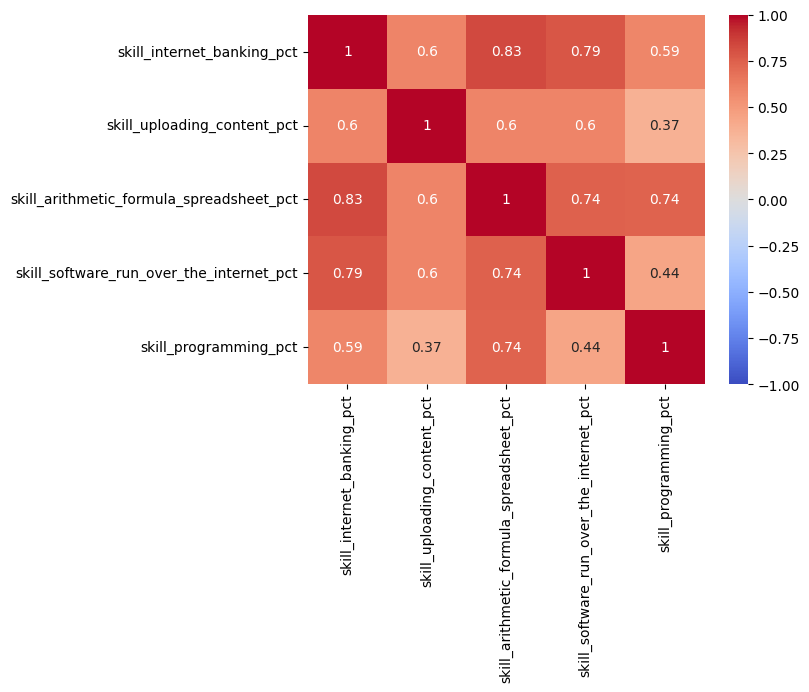

In [38]:
# Calculate the correlation matrix
correlation_matrix = vif_xvar.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', vmin=-1,annot=True, vmax=1)

In [39]:
# VIF on intermediate financial outcomes

before_inter = calculate_VIF(Intermediate_Outcomes_df)

vif_intermediate = Intermediate_Outcomes_df.drop(columns=(['account_pct','borrowed_formal_mobile_pct','digital_payment_made_received_pct','store_money_fin_account_pct','store_money_fin_account_with_acc_pct','saved_fin_account_pct','store_money_fin_account_or_mobile_account_pct','store_money_fin_account_or_mobile_account_with_acc_pct','digital_payment_made_pct','used_phone_or_internet_bills_pct','fin_account_pct','used_phone_or_internet_buy_pct']))
VIF_results_intermediate = calculate_VIF(vif_intermediate)
print(before_inter)
print(VIF_results_intermediate)

                                             features    VIF_value
0                                         account_pct   833.487222
1                          borrowed_formal_mobile_pct   688.070470
2                             borrowed_for_health_pct    10.437993
3                            borrowed_from_formal_pct   662.358924
4                                     fin_account_pct   591.472293
5                            digital_payment_made_pct   618.299517
6                   digital_payment_made_received_pct   910.034632
7                                  received_wages_pct    39.282308
8                               saved_fin_account_pct   484.970396
9                     saved_fin_account_or_mobile_pct   466.850220
10                        store_money_fin_account_pct  2930.908961
11               store_money_fin_account_with_acc_pct   442.087554
12      store_money_fin_account_or_mobile_account_pct  2986.552245
13  store_money_fin_account_or_mobile_account_with...   472.74

<Axes: >

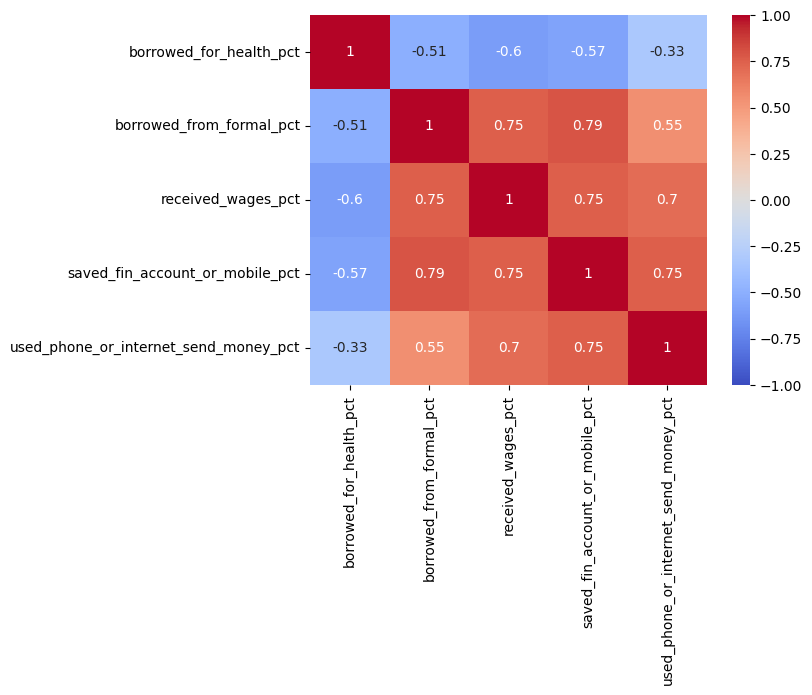

In [40]:
# Calculate the correlation matrix
correlation_matrix = vif_intermediate.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', vmin=-1,annot=True, vmax=1)

In [41]:
# VIF on controls 
#test_VIF = calculate_VIF(Controls_df)

before_control = calculate_VIF(Controls_df)

vif_control = Controls_df.drop(columns=(['offline_population_pct','internet_users ','Fixed_line_broadband subscribers_pct','fixed_broadband_download_speed','fixed_broadband_upload_speed','mobile_download_speed','efinance_value','total_fixed_broadband_subs']))
VIF_results_controls = calculate_VIF(vif_control)
print(before_control)

                                             features     VIF_value
0                                  internet_users_pct  1.212143e+01
1                                internet_users_pct.1  3.067059e+01
2                Fixed_line_broadband subscribers_pct  1.337033e+01
3                              mobile_subscribers_pct  3.813287e+00
4                        fixed_broadband_upload_speed  8.356668e+00
5                      fixed_broadband_download_speed  1.664380e+01
6                                 mobile_upload_speed  6.003870e+00
7                               mobile_download_speed  7.654117e+00
8                                     2G_coverage_pct  6.137621e+00
9                                     3G_coverage_pct  8.093813e+00
10                                    4G_coverage_pct  1.173202e+01
11                                    smartphone_cost  1.095866e+01
12                                mobile_cost_prepaid  7.393445e+00
13                               mobile_cost_pos

d:\Documents\LUMS\7th Semester Courses\ML\ml\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
d:\Documents\LUMS\7th Semester Courses\ML\ml\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [42]:
print("After reducing vars", VIF_results_controls)

After reducing vars                                              features  VIF_value
0                                  internet_users_pct  11.305927
1                                internet_users_pct.1  28.689400
2                              mobile_subscribers_pct   2.577860
3                                 mobile_upload_speed   2.549470
4                                     2G_coverage_pct   5.237411
5                                     3G_coverage_pct   6.901411
6                                     4G_coverage_pct   8.989884
7                                     smartphone_cost  10.651389
8                                 mobile_cost_prepaid   5.878560
9                                mobile_cost_postpaid   4.667871
10                               fixed_broadband_cost   2.634347
11                                   efinance_content   3.446463
12                                       literacy_pct   8.092409
13                                 edu_attainment_pct  11.457524
14   

<Axes: >

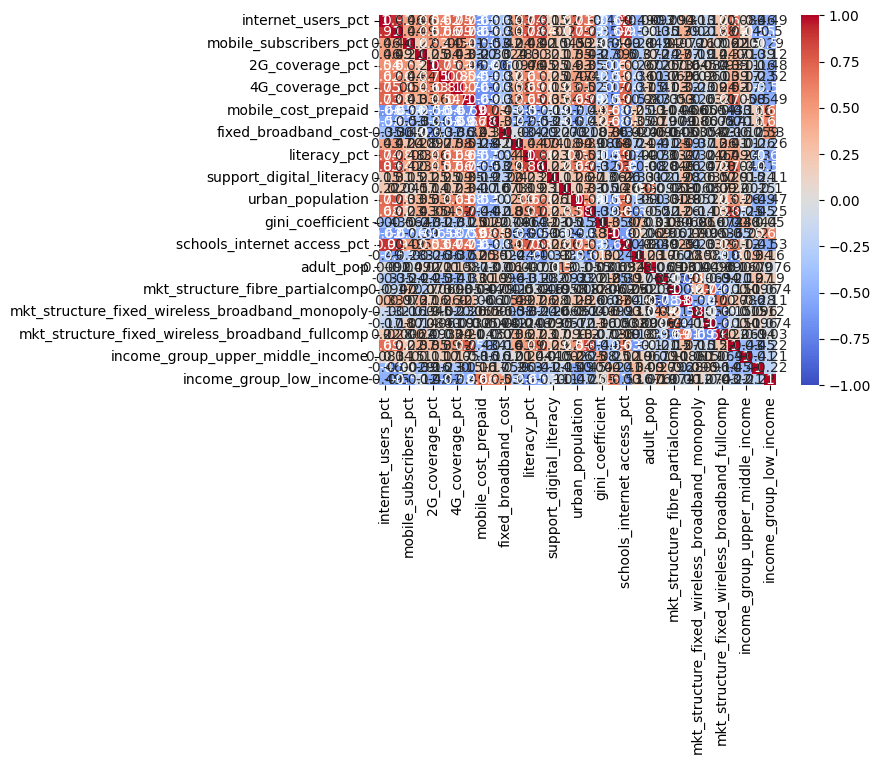

In [43]:
# Calculate the correlation matrix
correlation_matrix = vif_control.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', vmin=-1,annot=True, vmax=1)

## Final Dataset (some additions)

In [44]:
final_data = filtered_merged_data.drop(columns=['offline_population_pct','internet_users ','Fixed_line_broadband subscribers_pct','fixed_broadband_download_speed','fixed_broadband_upload_speed','mobile_download_speed','efinance_value','total_fixed_broadband_subs','account_pct','borrowed_formal_mobile_pct','digital_payment_made_received_pct','store_money_fin_account_pct','store_money_fin_account_with_acc_pct','saved_fin_account_pct','store_money_fin_account_or_mobile_account_pct','store_money_fin_account_or_mobile_account_with_acc_pct','digital_payment_made_pct','used_phone_or_internet_bills_pct','fin_account_pct','used_phone_or_internet_buy_pct','skill_transferring_files_pct','skill_installing_software_pct','own_mobile_pct','own_card_pct','skill_copy_and_paste_pct','skill_software_run_over_the_internet_urban_pct'])

label_mapping = {
    'Control': 1,
    'X Variable': 2,
    'Intermediate Outcomes': 3,
    'Financial well-being': 4
}

# Apply the mapping to the first row and use 0 for missing labels
final_data.iloc[0] = final_data.iloc[0].apply(lambda x: label_mapping.get(x, 0))

In [45]:
# for regional analysis, attaching regions as well
country_to_region = {
    "Algeria": "Africa", "Angola": "Africa", "Argentina": "South America", 
    "Australia": "Oceania", "Austria": "Europe", "Bahrain": "Middle East",
    "Bangladesh": "Asia", "Belgium": "Europe", "Benin": "Africa",
    "Botswana": "Africa", "Brazil": "South America", "Bulgaria": "Europe",
    "Burkina Faso": "Africa", "Cambodia": "Asia", "Cameroon": "Africa",
    "Canada": "North America", "Chile": "South America", "China": "Asia",
    "Colombia": "South America", "Congo (DRC)": "Africa", "Côte d'Ivoire": "Africa",
    "Cuba": "North America", "Denmark": "Europe", "Dominican Republic": "North America",
    "Egypt": "Africa", "El Salvador": "North America", "Estonia": "Europe",
    "Ethiopia": "Africa", "France": "Europe", "Gabon": "Africa",
    "Germany": "Europe", "Ghana": "Africa", "Greece": "Europe",
    "Guatemala": "North America", "Honduras": "North America", "Hungary": "Europe",
    "India": "Asia", "Indonesia": "Asia", "Iran": "Middle East",
    "Ireland": "Europe", "Italy": "Europe", "Jamaica": "North America",
    "Japan": "Asia", "Jordan": "Middle East", "Kazakhstan": "Asia",
    "Kenya": "Africa", "Kuwait": "Middle East", "Lebanon": "Middle East",
    "Liberia": "Africa", "Lithuania": "Europe", "Madagascar": "Africa",
    "Malawi": "Africa", "Malaysia": "Asia", "Mali": "Africa",
    "Mexico": "North America", "Mongolia": "Asia", "Morocco": "Africa",
    "Mozambique": "Africa", "Myanmar": "Asia", "Namibia": "Africa",
    "Netherlands": "Europe", "New Zealand": "Oceania", "Nigeria": "Africa",
    "Oman": "Middle East", "Pakistan": "Asia", "Panama": "North America",
    "Paraguay": "South America", "Peru": "South America", "Philippines": "Asia",
    "Poland": "Europe", "Portugal": "Europe", "Qatar": "Middle East",
    "Romania": "Europe", "Russia": "Europe", "Rwanda": "Africa",
    "Saudi Arabia": "Middle East", "Senegal": "Africa", "Singapore": "Asia",
    "South Africa": "Africa", "South Korea": "Asia", "Spain": "Europe",
    "Sri Lanka": "Asia", "Sudan": "Africa", "Sweden": "Europe",
    "Switzerland": "Europe", "Taiwan": "Asia", "Tanzania": "Africa",
    "Thailand": "Asia", "Trinidad & Tobago": "North America", "Tunisia": "Africa",
    "Turkey": "Middle East", "UAE": "Middle East", "Uganda": "Africa",
    "United Kingdom": "Europe", "United States": "North America", "Uzbekistan": "Asia",
    "Venezuela": "South America", "Vietnam": "Asia", "Zambia": "Africa", 
    "Zimbabwe": "Africa"
}

In [46]:
final_data['region'] = final_data['country'].map(country_to_region)
final_data.at[0, 'region'] = 1

In [47]:
regions = ['Africa', 'South America', 'Oceania', 'Europe', 'Asia', 'North America', 'Middle East']

# Create new columns for each region
for region in regions:
    final_data[f'region_{region}'] = final_data['region'].apply(lambda x: 1 if x == region else 0)

# adding control label
region_columns = [f'region_{region}' for region in regions]
final_data.loc[0, region_columns] = 1

final_data = final_data.drop(columns=['region'])

In [48]:
# rearranging

# Get the columns in order based on the values in row 0 (first row)
columns_order = final_data.iloc[0].sort_values().index.tolist()

# Reorder the DataFrame based on this sorted order
final_data = final_data[columns_order]
final_data.iloc[:, 3:] = final_data.iloc[:, 3:].apply(pd.to_numeric, errors='coerce')

In [51]:
# outputing final dataset
output_file = 'final_data.xlsx'  # Specify the file name
final_data.to_excel(output_file, index=False)  # Set index=False to exclude the DataFrame index in the file


## Extracting data for 2017

In [52]:
columns_created_later = ['mkt_structure_fibre_monopoly', 'mkt_structure_fibre_partialcomp', 'mkt_structure_fibre_fullcomp', 'mkt_structure_fixed_wireless_broadband_monopoly', 'region_North America', 'mkt_structure_fixed_wireless_broadband_fullcomp', 'income_group_upper_middle_income', 'income_group_lower_middle_income', 'income_group_low_income', 'region_Africa', 'region_South America', 'region_Oceania', 'region_Europe', 'region_Asia', 'income_group_high_income', 'mkt_structure_fixed_wireless_broadband_partialcomp', 'region_Middle East', 'not_worried_index', 'somewhat_worried_index', 'very_worried_index', 'worried_index', 'region']
columns_for_2017 = final_data.columns[pd.to_numeric(final_data.iloc[0], errors='coerce') <= 3].tolist()
columns_after_removal = [col for col in columns_for_2017 if col not in columns_created_later]
columns_to_keep = columns_after_removal + ['mkt_structure_fibre', 'mkt_structure_fixed_wireless_broadband', 'income_group']
relevant_countries = final_data.iloc[:, 0]

data_2017 = whole_Data[(whole_Data['year'] == 2017) & (whole_Data.iloc[:, 0].isin(relevant_countries))][columns_to_keep]

In [53]:
# remaking those encoded columns
data_2017['region'] = data_2017['country'].map(country_to_region)
data_2017.at[0, 'region'] = 1

for region in regions:
    data_2017[f'region_{region}'] = data_2017['region'].apply(lambda x: 1 if x == region else 0)

# adding control label
region_columns = [f'region_{region}' for region in regions]
data_2017.loc[0, region_columns] = 1

data_2017 = data_2017.drop(columns=['region'])

In [54]:
# mkt_structure_fibre
data_2017['mkt_structure_fibre_monopoly'] = data_2017['mkt_structure_fibre'].apply(
    lambda x: 1 if x == 'Monopoly' else 0 if x in ['Full competition (year when competition was introduced)', 'Partial competition (year when competition was introduced)'] else x)

data_2017['mkt_structure_fibre_partialcomp'] = data_2017['mkt_structure_fibre'].apply(
    lambda x: 1 if x == 'Partial competition (year when competition was introduced)' else 0 if x in ['Full competition (year when competition was introduced)', 'Monopoly'] else x)

data_2017['mkt_structure_fibre_fullcomp'] = data_2017['mkt_structure_fibre'].apply(
    lambda x: 1 if x == 'Full competition (year when competition was introduced)' else 0 if x in ['Monopoly', 'Partial competition (year when competition was introduced)'] else x)

data_2017 = data_2017.drop(columns=['mkt_structure_fibre'])

In [55]:
# mkt_structure_fixed_wireless_broadband

data_2017['mkt_structure_fixed_wireless_broadband_monopoly'] = data_2017['mkt_structure_fixed_wireless_broadband'].apply(
    lambda x: 1 if x == 'Monopoly' else 0 if x in ['Full competition (year when competition was introduced)', 'Partial competition (year when competition was introduced)'] else x)

data_2017['mkt_structure_fixed_wireless_broadband_partialcomp'] = data_2017['mkt_structure_fixed_wireless_broadband'].apply(
    lambda x: 1 if x == 'Partial competition (year when competition was introduced)' else 0 if x in ['Full competition (year when competition was introduced)', 'Monopoly'] else x)

data_2017['mkt_structure_fixed_wireless_broadband_fullcomp'] = data_2017['mkt_structure_fixed_wireless_broadband'].apply(
    lambda x: 1 if x == 'Full competition (year when competition was introduced)' else 0 if x in ['Monopoly', 'Partial competition (year when competition was introduced)'] else x)

data_2017 = data_2017.drop(columns=['mkt_structure_fixed_wireless_broadband'])

In [56]:
# income_group

data_2017['income_group_high_income'] = data_2017['income_group'].apply(
    lambda x: 1 if x == 'High income' else 0 if x in ['Upper middle income', 'Lower middle income','Low income'] else x)

data_2017['income_group_upper_middle_income'] = data_2017['income_group'].apply(
    lambda x: 1 if x == 'Upper middle income' else 0 if x in ['High income', 'Lower middle income','Low income'] else x)

data_2017['income_group_lower_middle_income'] = data_2017['income_group'].apply(
    lambda x: 1 if x == 'Lower middle income' else 0 if x in ['Upper middle income', 'High income','Low income'] else x)

data_2017['income_group_low_income'] = data_2017['income_group'].apply(
    lambda x: 1 if x == 'Low income' else 0 if x in ['Upper middle income', 'Lower middle income','High income'] else x)

data_2017 = data_2017.drop(columns=['income_group'])

In [57]:
output_file = '2017_Data.xlsx'  # Specify the file name
data_2017.to_excel(output_file, index=False)  # Set index=False to exclude the DataFrame index in the file

# Exploratory Data Analysis

In [58]:
eda_data = final_data.iloc[1:].copy()

In [59]:
# summary stats on numeric values ofc
summary_stats = eda_data.iloc[:,3:].describe()
summary_stats

,region_North America,region_Africa,region_South America,region_Oceania,region_Europe,region_Asia,region_Middle East
count,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000
mean,0.109756,0.292683,0.073171,0.024390,0.243902,0.207317,0.048780
std,0.314509,0.457794,0.262019,0.155207,0.432077,0.407879,0.216734
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Across Income Levels

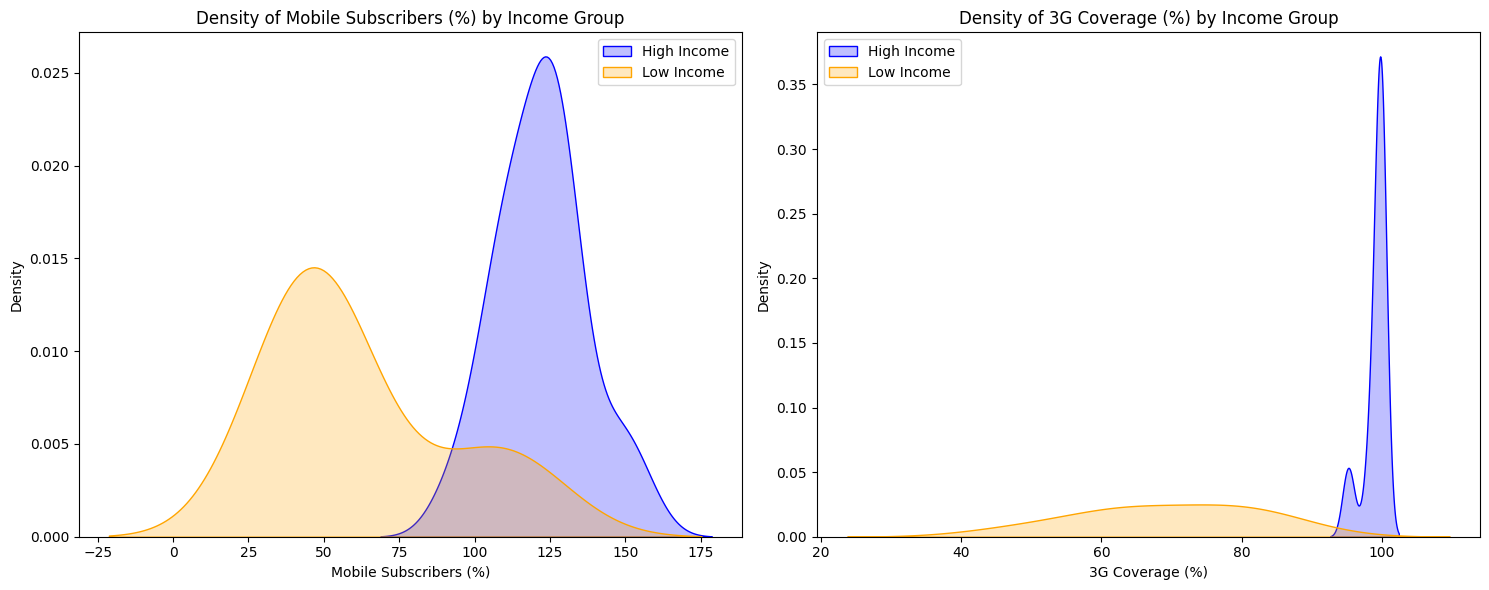

In [ ]:
# Internet Related Metrics

import seaborn as sns
import matplotlib.pyplot as plt

# Filter the data for high income and low income groups only
high_income_data = eda_data[eda_data['income_group_high_income'] == 1]
low_income_data = eda_data[eda_data['income_group_low_income'] == 1]

# Variables to plot density for
vars_to_plot = ["mobile_subscribers_pct", "3G_coverage_pct"]

# Set up the subplots for density curves
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # One row, two columns for the two variables

# Plot density for mobile_subscribers_pct
sns.kdeplot(data=high_income_data, x="mobile_subscribers_pct", label="High Income", ax=axes[0], color="blue", fill=True)
sns.kdeplot(data=low_income_data, x="mobile_subscribers_pct", label="Low Income", ax=axes[0], color="orange", fill=True)
axes[0].set_title("Density of Mobile Subscribers (%) by Income Group")
axes[0].set_xlabel("Mobile Subscribers (%)")
axes[0].set_ylabel("Density")
axes[0].legend()

# Plot density for 3G_coverage_pct
sns.kdeplot(data=high_income_data, x="3G_coverage_pct", label="High Income", ax=axes[1], color="blue", fill=True)
sns.kdeplot(data=low_income_data, x="3G_coverage_pct", label="Low Income", ax=axes[1], color="orange", fill=True)
axes[1].set_title("Density of 3G Coverage (%) by Income Group")
axes[1].set_xlabel("3G Coverage (%)")
axes[1].set_ylabel("Density")
axes[1].legend()

plt.tight_layout()
plt.show()


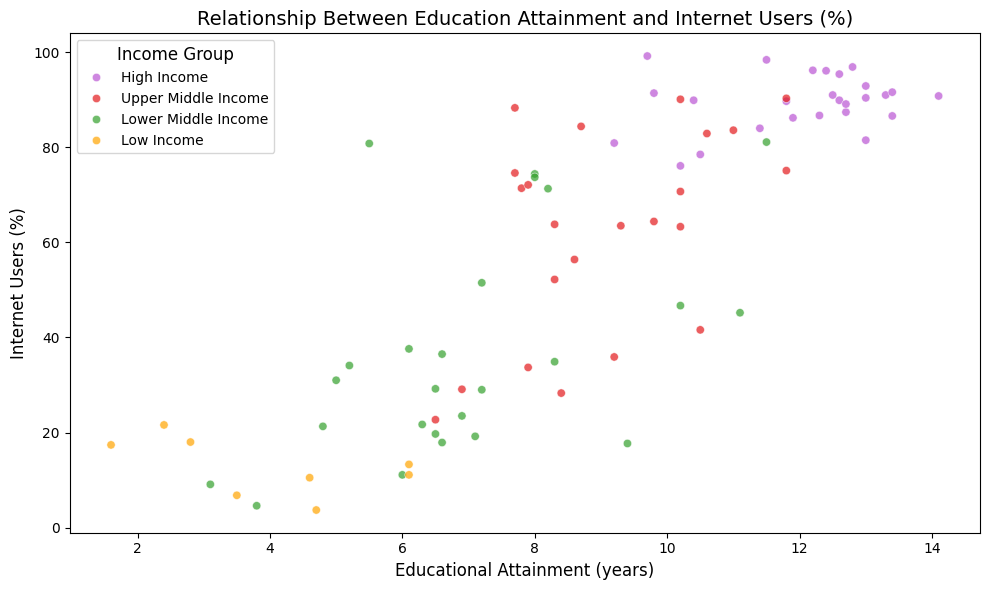

In [93]:
# Internet and Educational Attainment



# Define the color palette explicitly with a slightly darker purple
custom_palette = {
    'High Income': '#BA55D3',  # Medium orchid (darker purple)
    'Upper Middle Income': '#E31A1C',  # Red (Set1 color for upper middle income)
    'Lower Middle Income': '#33A02C',  # Green (Set1 color for lower middle income)
    'Low Income': 'orange'  # Orange for low income
}

# Define the desired order for the legend
income_order = ['High Income', 'Upper Middle Income', 'Lower Middle Income', 'Low Income']

# Plotting the scatter plot with the custom palette and legend order
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=eda_data, 
    x="edu_attainment_pct", 
    y="internet_users_pct", 
    hue="income_group_hue", 
    palette=custom_palette, 
    hue_order=income_order, 
    alpha=0.7  # Transparency for points
)
plt.title("Relationship Between Education Attainment and Internet Users (%)", fontsize=14)
plt.xlabel("Educational Attainment (years)", fontsize=12)
plt.ylabel("Internet Users (%)", fontsize=12)
plt.legend(title="Income Group", fontsize=10, title_fontsize=12)
plt.tight_layout()
plt.show()




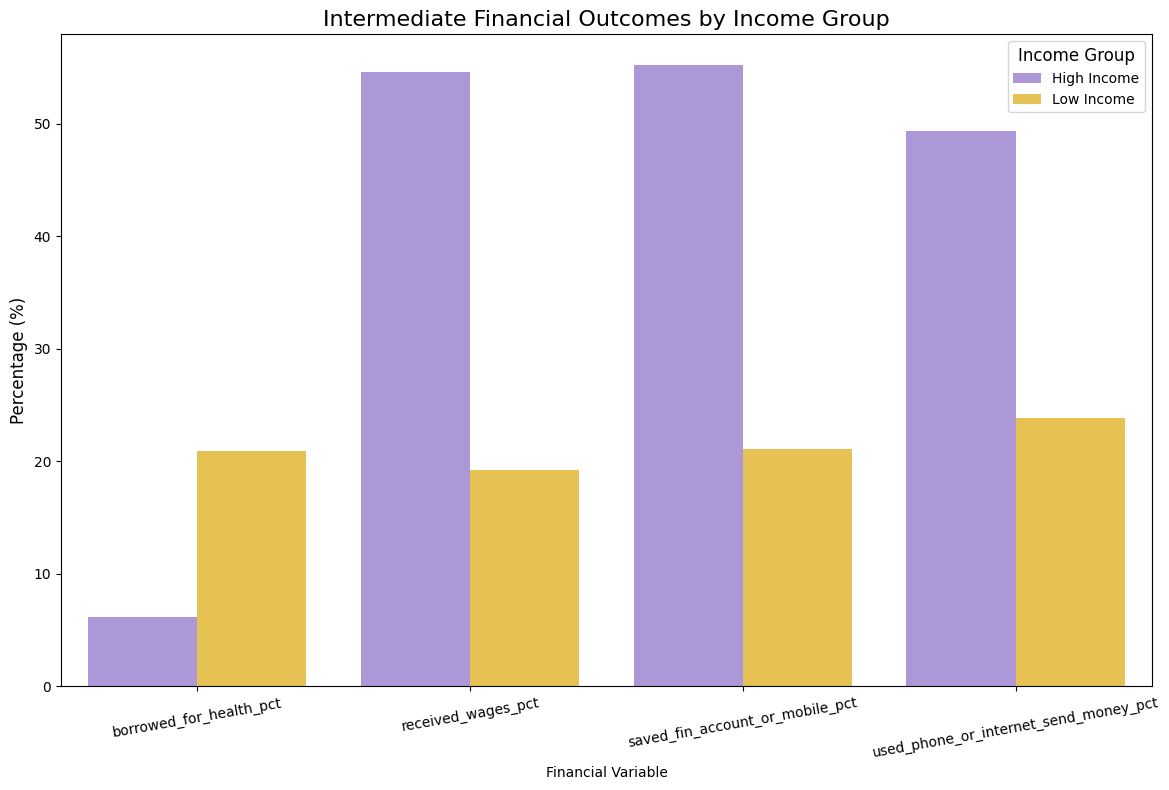

In [122]:
# Variation in intermediate outcomes


import seaborn as sns
import matplotlib.pyplot as plt

# Filter data to include only rows where income is either high or low
income_data = eda_data[(eda_data['income_group_high_income'] == 1) | 
                         (eda_data['income_group_low_income'] == 1)].copy()

# Add a new column to categorize as 'High Income' or 'Low Income'
income_data['Income Group'] = income_data.apply(
    lambda row: 'High Income' if row['income_group_high_income'] == 1 else 'Low Income', axis=1
)

# List of variables to plot
financial_vars = [
    'borrowed_for_health_pct', 
    'received_wages_pct', 
    'saved_fin_account_or_mobile_pct', 
    'used_phone_or_internet_send_money_pct'
]

# Calculate the mean of each variable by income group
means = income_data.groupby('Income Group')[financial_vars].mean().reset_index().melt(
    id_vars="Income Group", var_name="Financial Variable", value_name="Percentage (%)"
)

# Define a custom color palette with slightly darker shades
custom_palette = {
    'High Income': '#9370DB',  # Slightly darker purple
    'Low Income': '#FFC30B'    # Slightly darker orange
}

# Plotting with Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(
    data=means, 
    x="Financial Variable", 
    y="Percentage (%)", 
    hue="Income Group", 
    palette=custom_palette, 
    alpha=0.8  # Subtle transparency
)

# Add titles and labels for a clean presentation
plt.title("Intermediate Financial Outcomes by Income Group", fontsize=16)
plt.ylabel("Percentage (%)", fontsize=12)
plt.xticks(rotation=10, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Income Group", fontsize=10, title_fontsize=12)

# Tight layout for better spacing
plt.tight_layout()
plt.show()





C:\Users\Khan Abdullah\AppData\Local\Temp\ipykernel_4608\2374429164.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


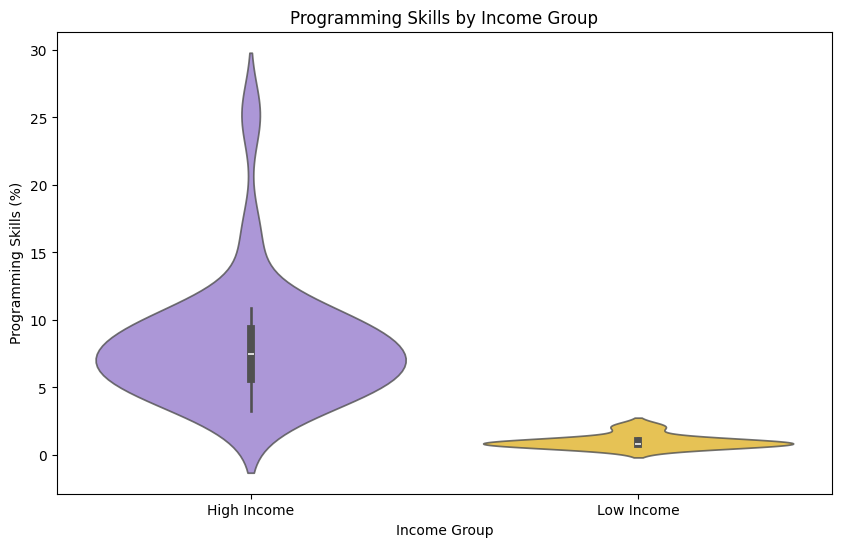

In [ ]:
# Programming skills against income level

import seaborn as sns
import matplotlib.pyplot as plt

# Filter data to include only rows where income is either high or low
income_data = eda_data[(eda_data['income_group_high_income'] == 1) | 
                       (eda_data['income_group_low_income'] == 1)].copy()

# Add a new column to categorize as 'High Income' or 'Low Income'
income_data['Income Group'] = income_data.apply(
    lambda row: 'High Income' if row['income_group_high_income'] == 1 else 'Low Income', axis=1
)

# Set up the plot with transparency for a cleaner look
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=income_data, 
    x='Income Group', 
    y='skill_programming_pct', 
    palette={"High Income": "#9370DB", "Low Income": "#FFC30B"},  # Blue for high income, orange for low income
    alpha = 0.8
)

# Add labels and title for a cleaner appearance
plt.title("Programming Skills by Income Group")
plt.ylabel("Programming Skills (%)")

plt.show()


## Across Regions

In [68]:
region_summary = eda_data[region_columns + key_variables].groupby(region_columns).describe()
region_summary

internet_users_pct  \
                                                                                                                                 count   
region_Africa region_South America region_Oceania region_Europe region_Asia region_North America region_Middle East                      
0             0                    0              0             0           0                    1                                 4.0   
                                                                            1                    0                                 9.0   
                                                                1           0                    0                                17.0   
                                                  1             0           0                    0                                20.0   
                                   1              0             0           0                    0                                 2.0   
              1                    0              0             0           0                    0                                 6.0   
1             0                    0              0             0           0                    0                                24.0   

                                                                                                                            \
                                                                                                                    unique   
region_Africa region_South America region_Oceania region_Europe region_Asia region_North America region_Middle East          
0             0                    0              0             0           0                    1                     4.0   
                                                                            1                    0                     9.0   
                                                                1           0                    0                    17.0   
                                                  1             0           0                    0                    20.0   
                                   1              0             0           0                    0                     2.0   
              1                    0              0             0           0                    0                     6.0   
1             0                    0              0             0           0                    0                    23.0   

                                                                                                                           \
                                                                                                                      top   
region_Africa region_South America region_Oceania region_Europe region_Asia region_North America region_Middle East         
0             0                    0              0             0           0                    1                   41.6   
                                                                            1                    0                   91.0   
                                                                1           0                    0                   37.6   
                                                  1             0           0                    0                   89.9   
                                   1              0             0           0                    0                   87.4   
              1                    0              0             0           0                    0                   82.9   
1             0                    0              0             0           0                    0                   11.1   

                                                                                                                          \
                                                                                                   

In [ ]:
# some regional analysis

# Group data by region and calculate mean for key variables
region_columns = ['region_Africa', 'region_South America', 'region_Oceania', 'region_Europe', 
                  'region_Asia', 'region_North America', 'region_Middle East']

key_variables = ['internet_users_pct', 'edu_attainment_pct', 'mobile_subscribers_pct', 
                 '2G_coverage_pct', '3G_coverage_pct', '4G_coverage_pct', 'nominal_gdp']

region_stats = final_data[region_columns + key_variables].groupby(region_columns).mean()
region_stats

internet_users_pct  \
region_Africa region_South America region_Oceania region_Europe region_Asia region_North America region_Middle East                      
0             0                    0              0             0           0                    1                              78.375   
                                                                            1                    0                           53.944444   
                                                                1           0                    0                           59.488235   
                                                  1             0           0                    0                                87.4   
                                   1              0             0           0                    0                               88.25   
              1                    0              0             0           0                    0                                60.1   
1             0                    0              0             0           0                    0                                29.0   
              1                    1              1             1           1                    1                                 1.0   

                                                                                                                    edu_attainment_pct  \
region_Africa region_South America region_Oceania region_Europe region_Asia region_North America region_Middle East                      
0             0                    0              0             0           0                    1                                9.15   
                                                                            1                    0                            9.244444   
                                                                1           0                    0                                 8.7   
                                                  1             0           0                    0                              11.935   
                                   1              0             0           0                    0                                12.7   
              1                    0              0             0           0                    0                            9.116667   
1             0                    0              0             0           0                    0                            5.920833   
              1                    1              1             1           1                    1                                 1.0   

                                                                                                                    mobile_subscribers_pct  \
region_Africa region_South America region_Oceania region_Europe region_Asia region_North America region_Middle East                          
0             0                    0              0             0           0                    1                                  89.025   
                                                                            1                    0                              108.466667   
                                                                1           0                    0                              130.929412   
                                                  1             0           0                    0                                 120.925   
                                   1              0             0           0                    0                                  116.65   
              1                    0              0             0           0                    0                                   119.7   
1             0                    0              0             0           0                    0                                 96.3875   
              1                    1              1             1           

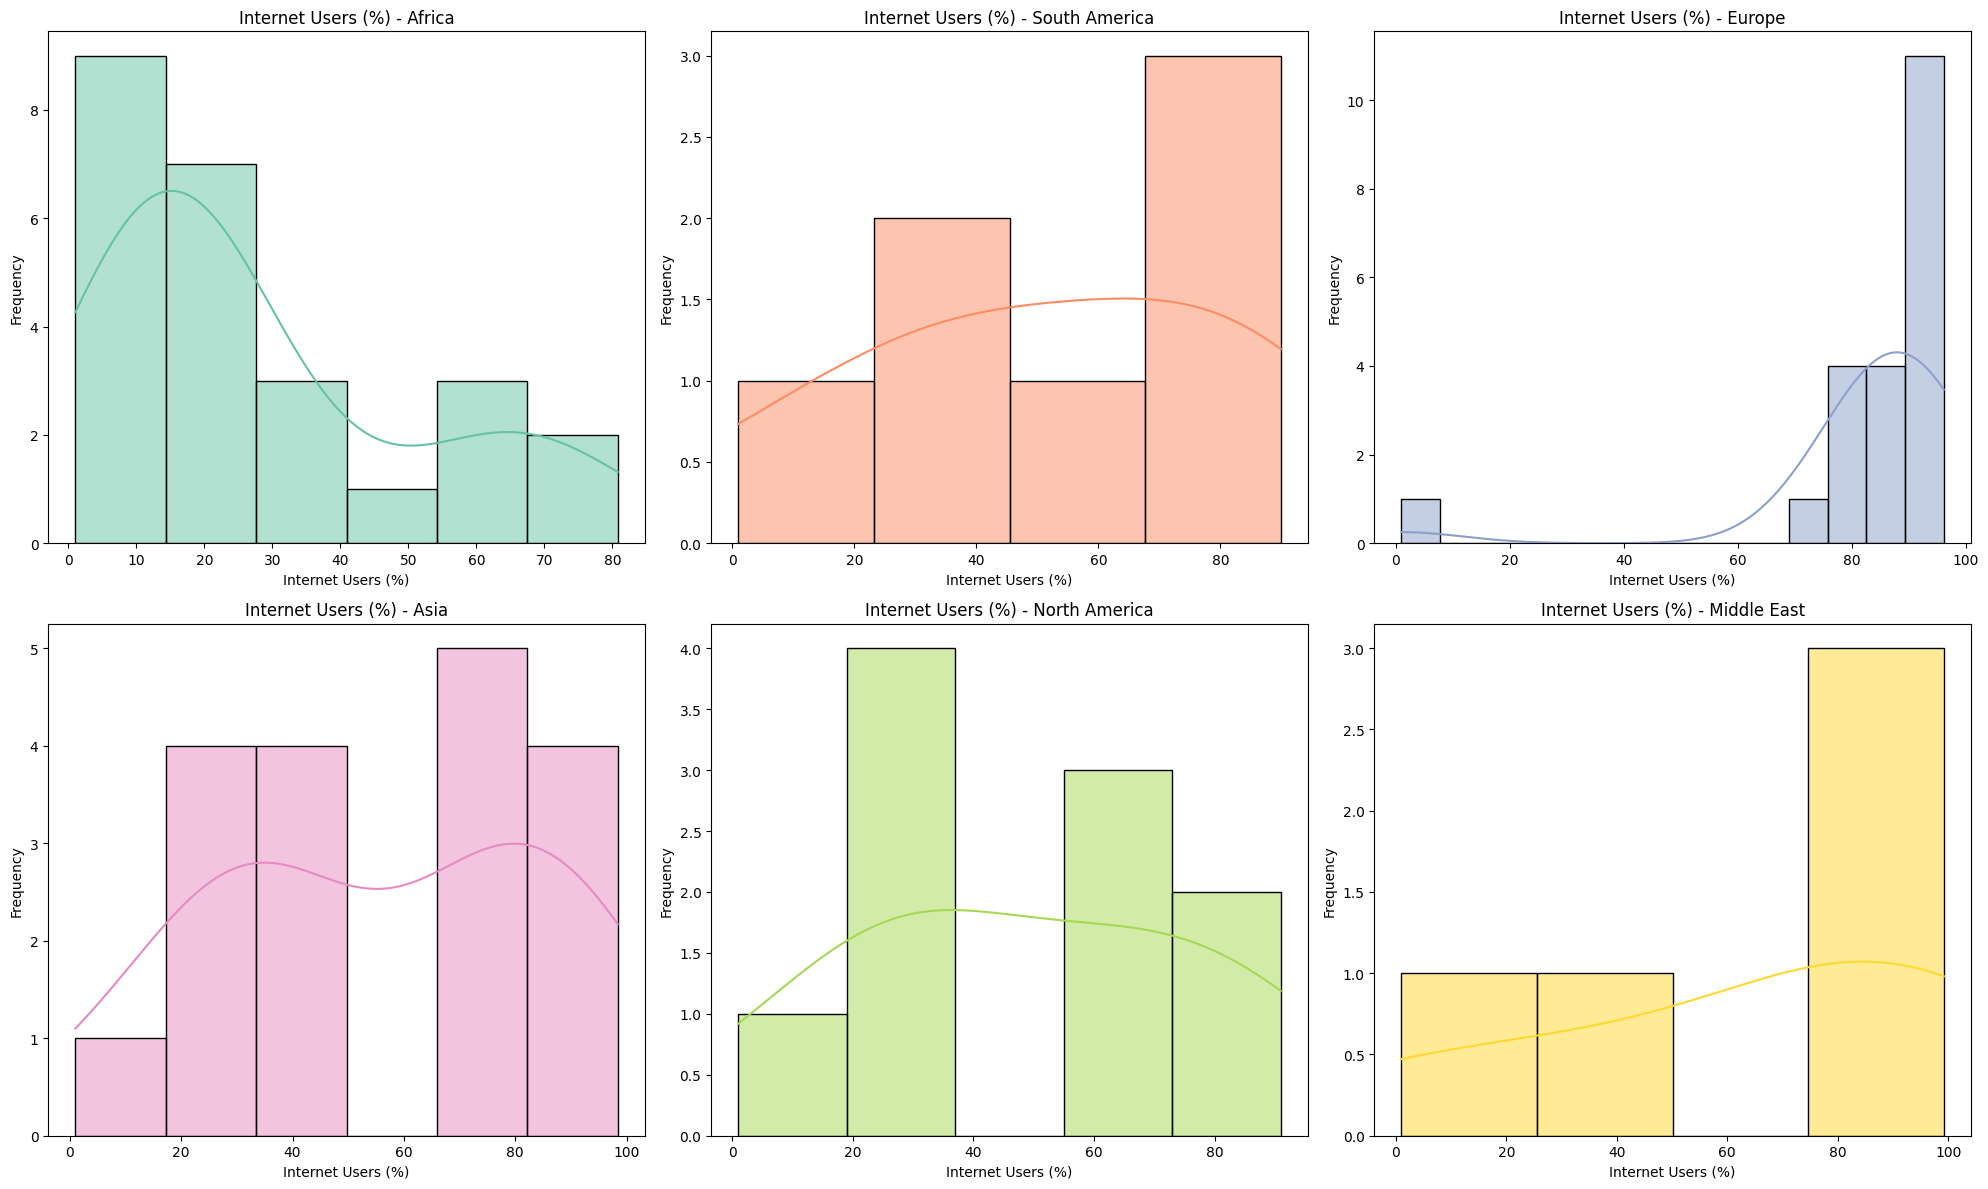

In [ ]:
# Internet Related Metrics

import seaborn as sns
import matplotlib.pyplot as plt

# Define the "Set2" palette colors for the regions
set2_colors = ["#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3", "#a6d854", "#ffd92f"]

# Set up the subplots (2 rows, 3 columns for 6 regions)
fig, axes = plt.subplots(2, 3, figsize=(20, 12))  # Adjust the size and grid for 6 regions
axes = axes.flatten()  # Flatten the axes array to make indexing easier

# List of regions to iterate over (removed 'Oceania')
regions = ["Africa", "South America", "Europe", "Asia", "North America", "Middle East"]

# Loop through each region and plot the histograms
for i, region in enumerate(regions):
    # Filter the data to only include rows where the region column is 1 (exclude 0 values)
    region_data = final_data[final_data[f'region_{region}'] == 1]

    # Create the histogram for each region with a specific color
    sns.histplot(
        data=region_data, 
        x="internet_users_pct", 
        kde=True, 
        ax=axes[i], 
        legend=False, 
        color=set2_colors[i]
    )
    
    axes[i].set_title(f"Internet Users (%) - {region}")
    axes[i].set_xlabel("Internet Users (%)")
    axes[i].set_ylabel("Frequency")

# Remove any extra subplots if the grid size is larger than the number of regions
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlap and ensure proper placement of subplots
plt.tight_layout()  # Adjust layout to avoid overlap

# Show the plot
plt.show()


C:\Users\Khan Abdullah\AppData\Local\Temp\ipykernel_4608\1448480947.py:21: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(
C:\Users\Khan Abdullah\AppData\Local\Temp\ipykernel_4608\1448480947.py:21: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(
C:\Users\Khan Abdullah\AppData\Local\Temp\ipykernel_4608\1448480947.py:21: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(
C:\Users\Khan Abdullah\AppData\Local\Temp\ipykern

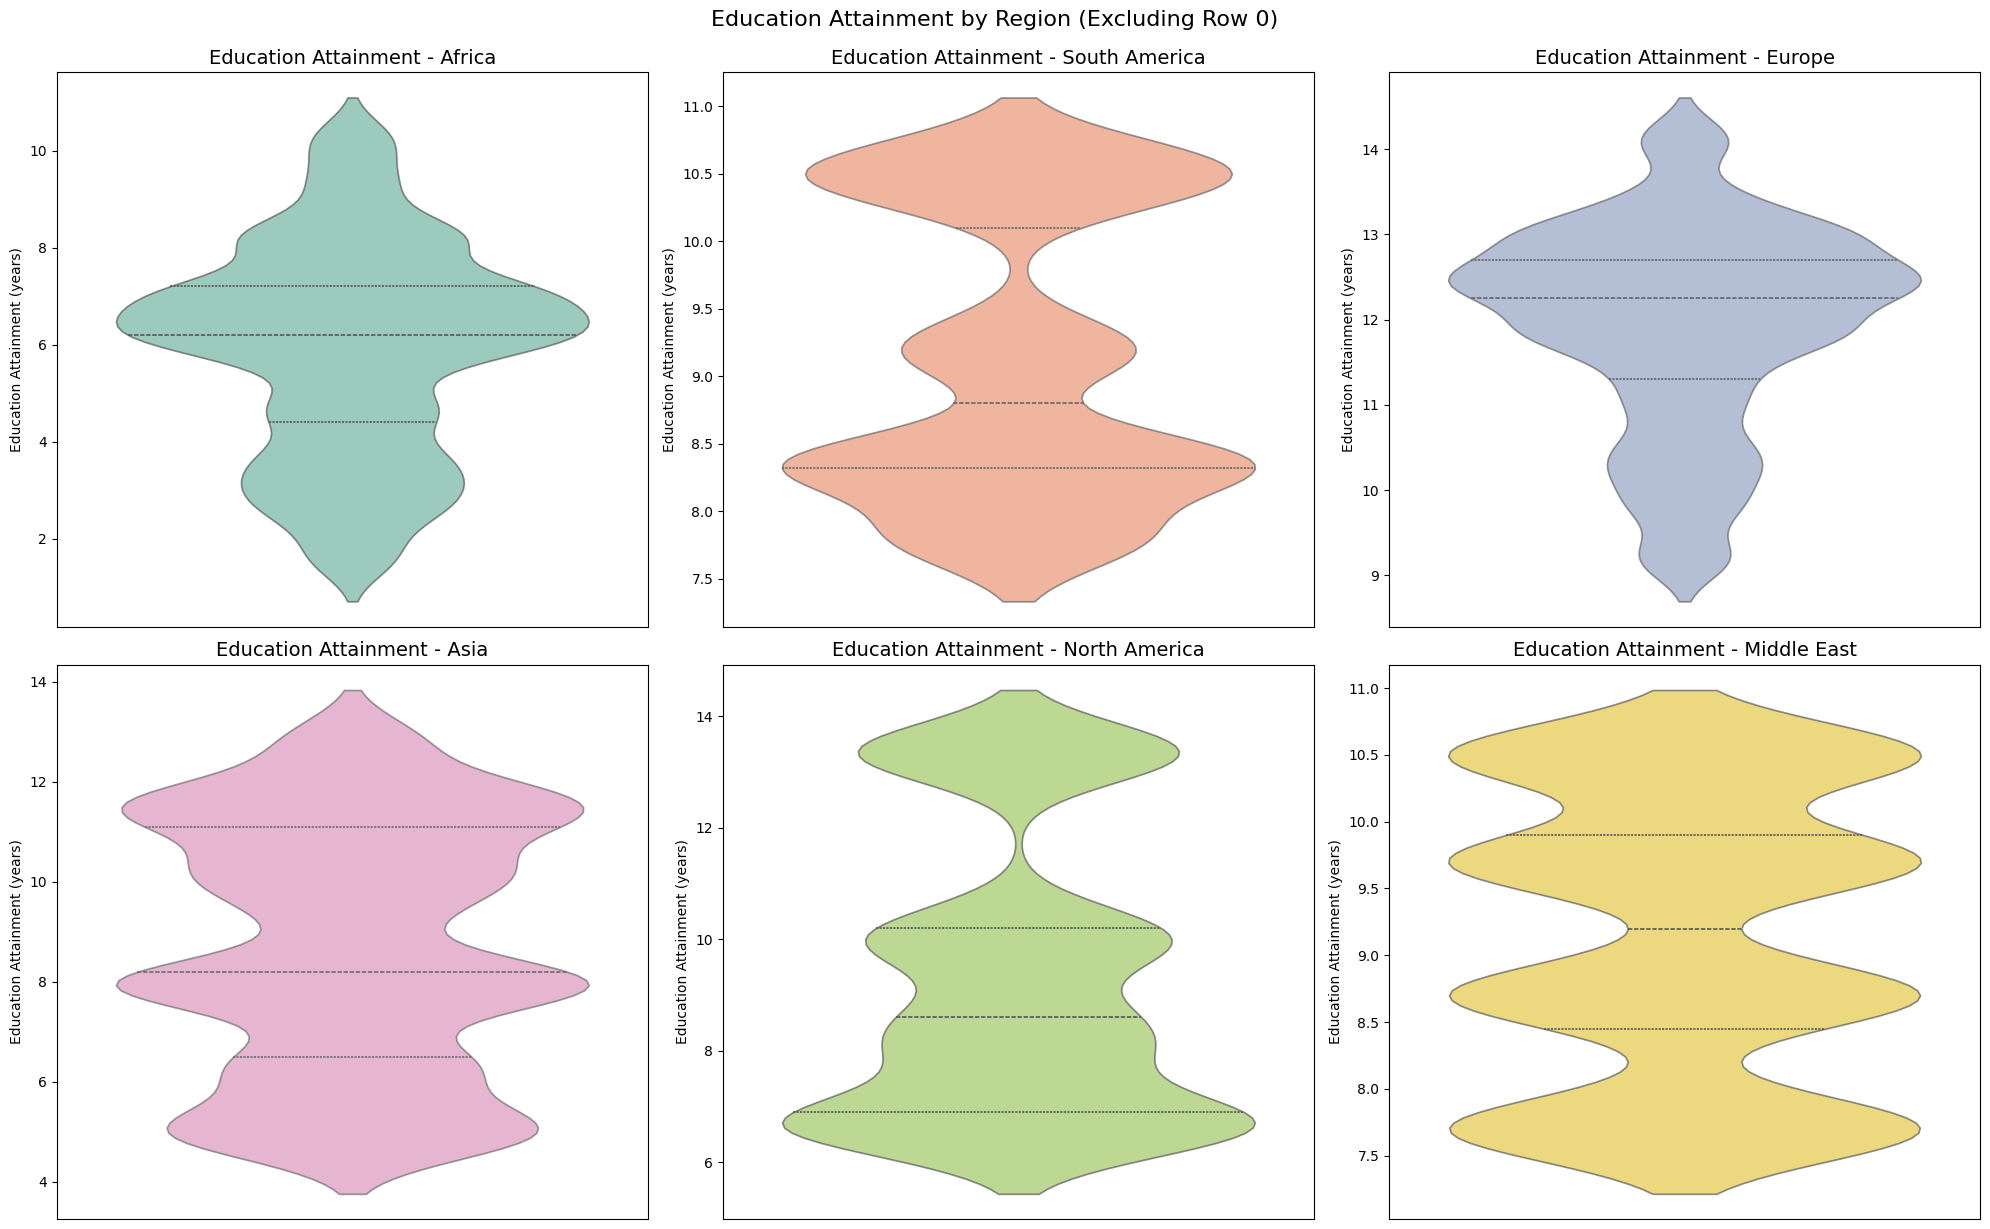

In [132]:
# Educational Attainment


import matplotlib.pyplot as plt
import seaborn as sns

# Define a color palette for the regions using Set2
set2_colors = ["#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3", "#a6d854", "#ffd92f"]

# Set up the subplots (2 rows, 3 columns for 6 regions)
fig, axes = plt.subplots(2, 3, figsize=(20, 12))  # Adjust the size and grid for 6 regions
axes = axes.flatten()  # Flatten the axes array to make indexing easier

# List of regions to iterate over (removed 'Oceania')
regions = ["Africa", "South America", "Europe", "Asia", "North America", "Middle East"]

# Loop through each region and plot the violin plot
for i, region in enumerate(regions):
    # Filter the data to only include rows where the region column is 1 (exclude 0 values)
    region_data = eda_data[eda_data[f'region_{region}'] == 1]
    
    if not region_data.empty:  # Ensure there is data to plot
        # Create the violin plot for each region
        sns.violinplot(
            data=region_data,
            x=[region] * len(region_data),  # Fake a categorical x-axis
            y="edu_attainment_pct",
            ax=axes[i],
            color=set2_colors[i],  # Assign a specific color for each region
            inner="quartile",  # Include quartile lines
            bw=0.2,  # Smoothing factor
            alpha=0.7  # Transparency
        )
        axes[i].set_title(f"Education Attainment - {region}", fontsize=14)
        axes[i].set_xlabel("")  # Remove x-axis label
        axes[i].set_ylabel("Education Attainment (years)", fontsize=10)
        axes[i].set_xticks([])  # Remove x-axis ticks for cleaner appearance

# Remove any extra subplots if the grid size is larger than the number of regions
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.suptitle("Education Attainment by Region (Excluding Row 0)", fontsize=16, y=1.02)

# Display the plot
plt.show()



C:\Users\Khan Abdullah\AppData\Local\Temp\ipykernel_4608\3424771782.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\Khan Abdullah\AppData\Local\Temp\ipykernel_4608\3424771782.py:25: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.boxplot(
C:\Users\Khan Abdullah\AppData\Local\Temp\ipykernel_4608\3424771782.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\Khan Abdullah\AppData\Local\Temp\ipykernel_4608\3424771782.py:25: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.boxplot(
C:\Users\Khan Abdullah\AppData\Local\Temp\ipykernel_4608\3424771782.py:25: FutureWarni

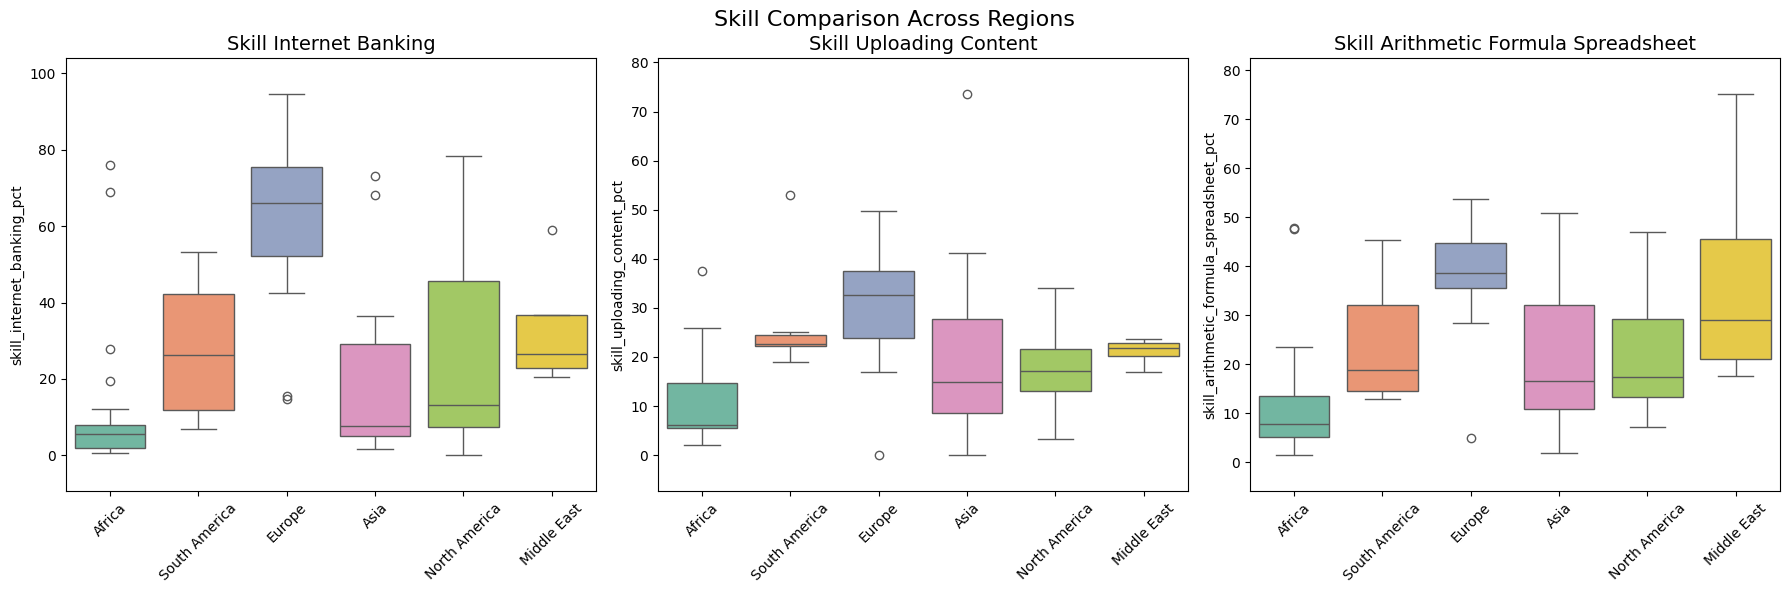

In [137]:
# X Variables across regions

import seaborn as sns
import matplotlib.pyplot as plt

# Select the first 3 skill-related columns (or any other number of skills)
skill_columns = [col for col in final_data.columns if col.startswith('skill_')][:3]  # Get the first 3 skill-related columns

# Dynamically create a region column if it doesn't already exist
if 'region' not in final_data.columns:
    final_data['region'] = final_data[[f'region_{r}' for r in regions]].idxmax(axis=1).str.replace('region_', '')

# List of regions to iterate over (including Oceania)
regions = ["Africa", "South America", "Europe", "Asia", "North America", "Middle East", "Oceania"]

# Extract the "Set2" palette from Seaborn
palette = sns.color_palette("Set2", n_colors=len(regions))

# Set up the subplots: the number of rows and columns depends on the number of skill columns
n_rows = (len(skill_columns) + 2) // 3  # Create enough rows to accommodate the number of skill columns
fig, axes = plt.subplots(n_rows, 3, figsize=(18, 6 * n_rows))  # Adjust the size and grid for the skill columns
axes = axes.flatten()  # Flatten the axes array to make indexing easier

# Loop through each skill column and create a plot for each region
for i, skill in enumerate(skill_columns):
    # Create the boxplot for each region for the current skill variable
    sns.boxplot(
        data=final_data,
        x="region",
        y=skill,
        ax=axes[i],
        palette=palette  # Use Seaborn's "Set2" palette for regions
    )
    
    # Title and labels (remove "_pct" and format nicely)
    axes[i].set_title(f"{skill.replace('_pct', '').replace('_', ' ').title()}", fontsize=14)  # Improve title clarity
    
    # Remove the x-axis label "region"
    axes[i].set_xlabel('')  # Remove x-axis label
    
    # Rotate x-tick labels for better readability
    axes[i].tick_params(axis='x', rotation=45, labelsize=10)  # Rotate x-axis labels and adjust font size

    # Optionally, adjust the y-axis to have a smaller margin
    y_min, y_max = final_data[skill].min(), final_data[skill].max()
    axes[i].set_ylim(y_min - (y_max - y_min) * 0.1, y_max + (y_max - y_min) * 0.1)  # Dynamic margin adjustment

# Remove any extra subplots if the grid size is larger than the number of skill columns
for j in range(len(skill_columns), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for more spacing and better visual clarity
plt.tight_layout()
plt.subplots_adjust(top=0.90, hspace=0.4)  # Increased top space and spacing between plots (hspace)
plt.suptitle("Skill Comparison Across Regions", fontsize=16)  # Add a meaningful overall title
plt.show()




C:\Users\Khan Abdullah\AppData\Local\Temp\ipykernel_4608\1884873953.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_data, x="Region", y="Percentage (%)", ax=ax, palette="Set2", inner="quartile", bw_adjust=0.2)


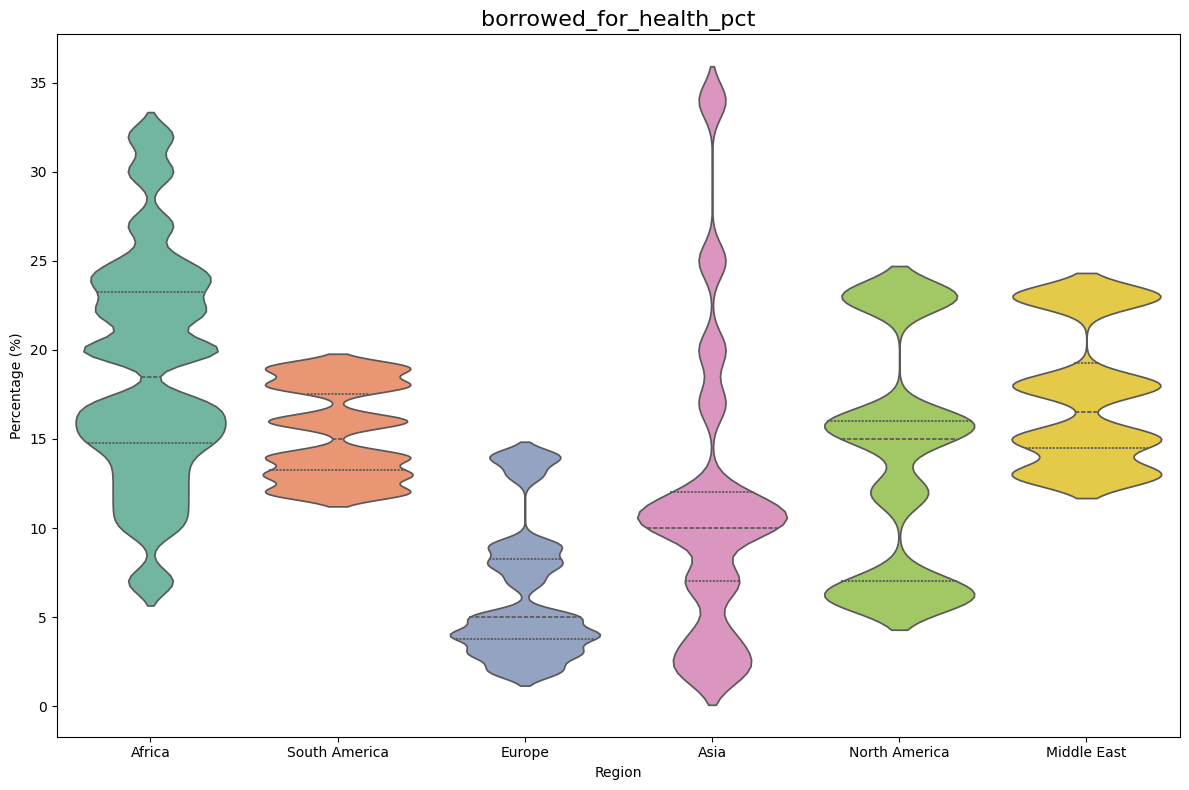

C:\Users\Khan Abdullah\AppData\Local\Temp\ipykernel_4608\1884873953.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_data, x="Region", y="Percentage (%)", ax=ax, palette="Set2", inner="quartile", bw_adjust=0.2)


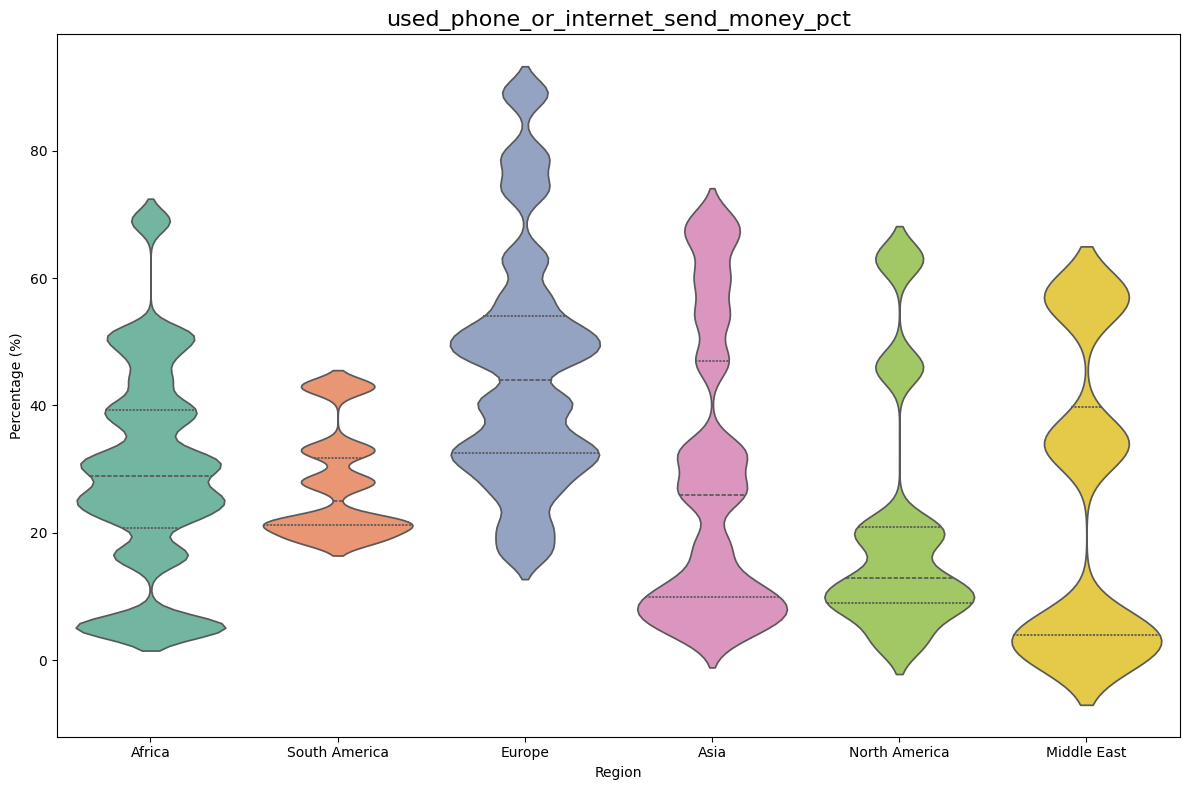

In [74]:
# Used phone or internet to send money and borrowed money for health against regions

import matplotlib.pyplot as plt
import seaborn as sns

# List of financial behavior variables
financial_vars = [
    'borrowed_for_health_pct',
    'used_phone_or_internet_send_money_pct'
]

# Define regions to iterate over (excluding 'Oceania' for a 2x3 grid)
regions = ["Africa", "South America", "Europe", "Asia", "North America", "Middle East"]

# Iterate over each financial behavior variable to create separate plots
for var in financial_vars:
    # Set up the plot for the current financial behavior variable
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Prepare data by selecting only the current variable and filtering by region
    plot_data = eda_data[eda_data[[f'region_{region}' for region in regions]].any(axis=1)]
    plot_data = plot_data.melt(id_vars=[f"region_{region}" for region in regions], value_vars=[var], var_name="Financial Behavior", value_name="Percentage (%)")
    
    # Add a region column to `plot_data` to identify the region each row belongs to
    for region in regions:
        plot_data.loc[plot_data[f"region_{region}"] == 1, "Region"] = region
    
    # Plot the violin plot for the current financial behavior variable across regions
    sns.violinplot(data=plot_data, x="Region", y="Percentage (%)", ax=ax, palette="Set2", inner="quartile", bw_adjust=0.2)
    
    # Customize the plot
    ax.set_title(f"{var}", fontsize=16)
    ax.set_ylabel("Percentage (%)")

    # Display the plot
    plt.tight_layout()
    plt.show()
